In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
# from torchsde import sdeint_adjoint as sdeint

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [6]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values
data2 = pd.read_csv('Data/amzn.us.txt')['Close'].values

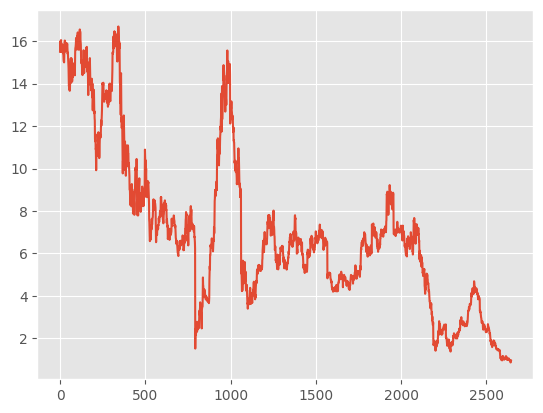

In [3]:
plt.plot(data)
# plt.plot(data2)

plt.show()

In [4]:
data = np.log1p(data)
data2 = np.log1p(data2)

In [5]:
data.shape

(2645,)

In [6]:
scaler = MinMaxScaler((0, 1))

data = scaler.fit_transform(data.reshape(-1, 1)).T[0]
data2 = scaler.fit_transform(data2.reshape(-1, 1)).T[0]

In [7]:
data2 = data2[:len(data)]

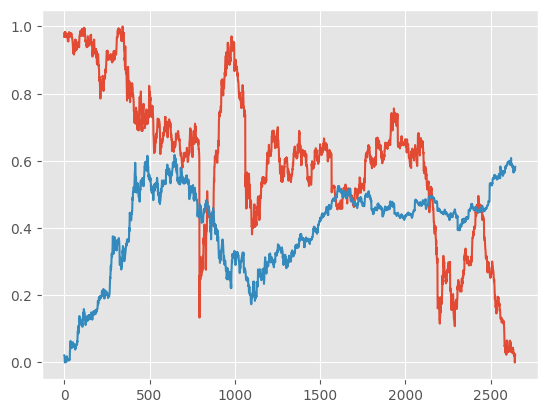

In [8]:
plt.plot(data)
plt.plot(data2)
plt.show()

In [9]:
data_tensor = torch.FloatTensor(np.vstack([data, data2]))
data0 = data_tensor[0]

In [10]:
data_tensor

tensor([[0.9690, 0.9797, 0.9823,  ..., 0.0000, 0.0196, 0.0226],
        [0.0209, 0.0197, 0.0155,  ..., 0.5743, 0.5740, 0.5823]])

In [2]:
def create_setA(data: np.array) -> torch.Tensor:
    set_A = torch.zeros(len(data), len(data))
    k = 1
    for i in range(len(data)):
        set_A[i, :k] = torch.FloatTensor(data[:k])
        k += 1
    
    return set_A

In [130]:
set_A = torch.stack(list(map(lambda x: create_setA(x), data)))

In [126]:
# set_A = create_setA(data)

# Baseline

### Data

In [12]:
def ornstein_uhlenbeck_process(n, m, mu):
    res = []
    theta = 1
    sigma = 0.5
    # mu = 0.0
    T = 1
    
    for j in range(m):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.random.normal(0, 0.1)
        dt = T/float(n)

        for t in range(n):
            x[t+1] = x[t] + theta*(mu - x[t]) * dt + sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1)
            time[t+1] = time[t] + dt

        res.append(x)
    
    return np.array(res).T

def dclProcess(N, M):
    T = 1
    theta = 1
    delta = 1

    Z1 = np.random.normal(0.0, 1.0, [M, N])
    X = np.zeros([M, N + 1])

    X[:, 0] = np.random.normal(0.0, 0.2, M)

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] >= 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] <= -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return X.T

def merton_process(s0, xiP, muj, sigmaj, r, sigma, n, T):
        time = np.zeros(n + 1)
        dt = T/float(n)
        
        z = np.random.normal(0.0, 1.0, n + 1)
        zj = np.random.normal(muj, sigmaj, n + 1)
        poisson_distr = np.random.poisson(xiP * dt, n + 1)
        
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        
        s[0] = s0
        x[0] = np.log(s0)
        
        EeJ = np.exp(muj + 0.5 * sigmaj**2)

        for t in range(n):
            x[t+1] = x[t] + (r - xiP * (EeJ - 1) - 0.5 * sigma**2) * dt +\
                sigma * np.sqrt(dt) * z[t] + zj[t] * poisson_distr[t]
            
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s
    
def geometric_BM(s0, mu, sigma, n, T):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.log(s0)
        dt = T/float(n)
        
        for t in range(n):
            x[t+1] = x[t] + (mu - (sigma**2)/2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
            time[t+1] = time[t] + dt
            
        s = np.exp(x)
        
        return s

In [423]:
# data = dclProcess(1000, 10).T
data = np.array([merton_process(s0=1, xiP=3, muj=0, sigmaj=0.3, r=0.04, sigma=0.6, n=500, T=1) for i in range(10)])
# data = geometric_BM(s0=1, mu=0.1, sigma=0.5, n=2000, T=1)

In [424]:
# data = np.log1p(data)

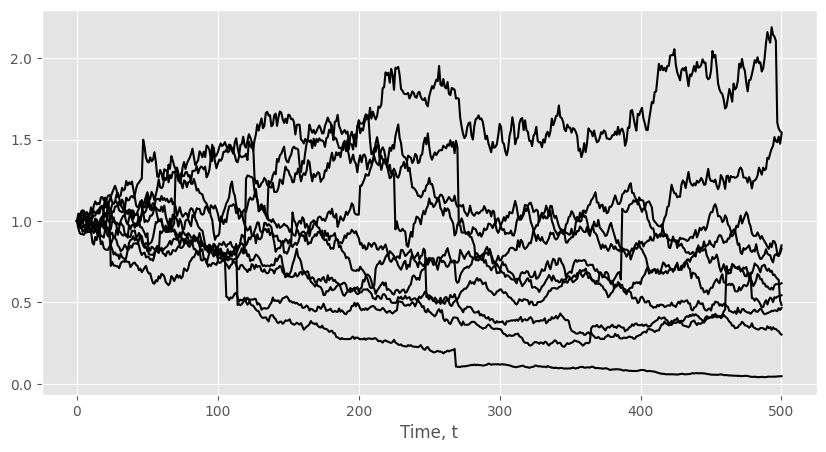

In [425]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T, color='black')

plt.xlabel('Time, t')
plt.show()

In [155]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T
# data = scaler.fit_transform(data.reshape(-1, 1)).reshape(1, -1)

In [426]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

In [427]:
data_tensor

tensor([[1.0000, 0.9551, 0.9255,  ..., 0.7842, 0.8162, 0.8505],
        [1.0000, 1.0078, 1.0048,  ..., 1.5178, 1.4742, 1.5336],
        [1.0000, 1.0184, 1.0195,  ..., 0.6386, 0.5119, 0.4844],
        ...,
        [1.0000, 0.9867, 0.9744,  ..., 0.7961, 0.7985, 0.8303],
        [1.0000, 0.9966, 0.9586,  ..., 1.5678, 1.5524, 1.5442],
        [1.0000, 1.0458, 1.0411,  ..., 0.0463, 0.0467, 0.0470]])

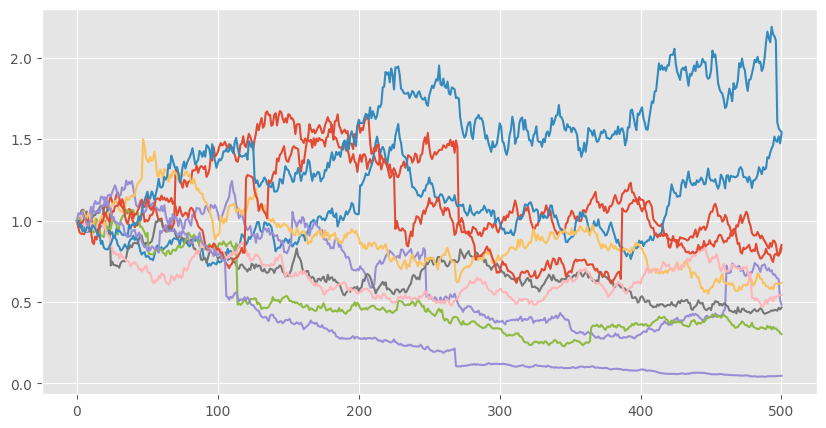

In [428]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_tensor.T)
plt.show()

## Identify jump intensity

In [498]:
def log_return(data):
    # data = data + 1e-3
    return np.log(data[1:]) - np.log(data[:-1])

def find_jumps(data: torch.Tensor, ths: float = 0.1):
    # jumps = torch.abs(data[:-1] - data[1:])
    jumps = torch.abs(log_return(data))
    idx_jumps = torch.where(jumps > ths)[0]
    
    return idx_jumps

idx_jumps = list(map(lambda x: find_jumps(x, 0.06), data_tensor))

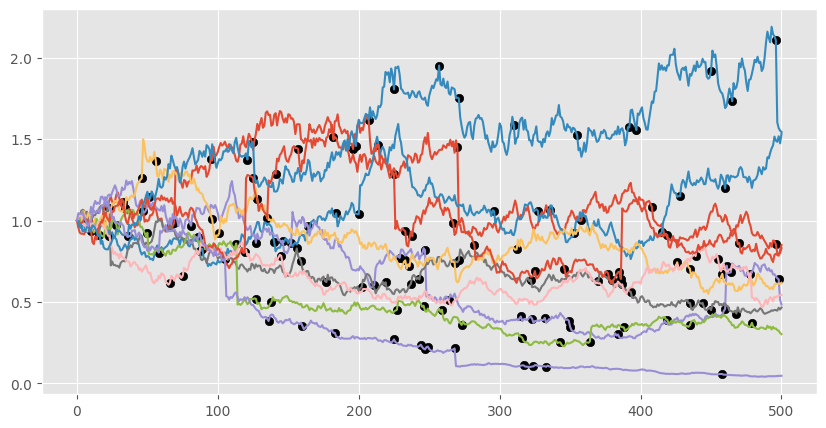

In [499]:
plt.subplots(figsize=(10, 5), dpi=100)

for i in range(len(data_tensor)):
    plt.plot(data_tensor[i])
    plt.scatter(idx_jumps[i], data_tensor[i][idx_jumps[i]], color='black')
    
plt.show()

In [500]:
def calc_mean_jump(data: list, idx: list):
    jumps = []
    for i in range(len(idx)):
        jumps.append(torch.mean(data[i][idx[i]]))
        
    jumps = torch.stack(jumps)
        
    return torch.mean(jumps[~jumps.isnan()])

In [501]:
calc_mean_jump(data_tensor, idx_jumps)

tensor(0.8419)

In [522]:
def estimate_init_intensity(data, idx_jumps) -> float:
    return len(idx_jumps) / len(data)

def estimate_init_intensity_array(data: torch.Tensor, idx_jumps: list) -> np.array:
    return np.array(list(map(lambda x,y: estimate_init_intensity(x, y), data, idx_jumps)))


def separate_dynamics(data: list, idx: list):
    jumps = []
    diff = []
    for i in range(len(idx)):
        jumps.append(data[i][idx[i]])
        diff.append(data[i][np.setdiff1d(np.arange(len(data[i])), idx[i])])
        
    return jumps, diff



def estimate_init_mu(data, dt):
    if data.size(0) == 1:
        return (2 * torch.mean(data) + torch.var(data) * dt) / (2 * dt)
    else:
        return (2 * torch.mean(data, dim=1) + torch.var(data, dim=1) * dt) / (2 * dt)
    
def estimate_init_var(data, dt):
    if data.size(0) == 1:
        return torch.var(data) / dt
    else:
        return torch.var(data, dim=1) / dt



def estimate_init_mu_j(data, dt, mu_hat, var_hat):
    if data.size(0) == 1:
        return torch.mean(data) - (mu_hat - var_hat/2) * dt
    else:
        return torch.mean(data, dim=1) - (mu_hat - var_hat/2) * dt
    
def estimate_init_var_j(data, dt, var_hat):
    if data.size(0) == 1:
        return torch.var(data) - var_hat * dt
    else:
        return torch.var(data, dim=1) - var_hat * dt
    
    
    
def estimate_init_params(data, jump_part, diff_part, dt):
    params = []
    for i in range(len(data)):
        r_j = log_return(jump_part[i]).view(1, -1)
        r_d = log_return(diff_part[i]).view(1, -1)
        
        mu_hat = estimate_init_mu(r_d, dt)
        var_hat = estimate_init_var(r_d, dt)
        
        mu_j_hat = estimate_init_mu_j(r_j, dt, mu_hat, var_hat)
        var_j_hat = estimate_init_var_j(r_j, dt, var_hat)
        
        params.append([mu_hat, var_hat, mu_j_hat, var_j_hat])
        
    return np.array(params)

In [523]:
init_intensity = estimate_init_intensity_array(data_tensor, idx_jumps)
init_intensity

array([0.01596806, 0.02195609, 0.04191617, 0.03592814, 0.0239521 ,
       0.03393214, 0.01596806, 0.04790419, 0.03193613, 0.02794411])

In [524]:
jump_part, diff_part = separate_dynamics(data_tensor, idx_jumps)

In [526]:
init_params = estimate_init_params(data_tensor, jump_part, diff_part, dt=0.01)

In [532]:
def likelihood_mjd(data, params, intensity, dt):
    like = 0
    for i in range(len(data)):
        for k in range(3):
            mu = (params[0] - params[1]/2) * dt + params[2] * k
            var = params[1] * dt + params[3] * k
            l = (intensity * dt)**k
            
            like += np.log( (l * np.exp(-intensity * dt) / factorial(k))  * (np.exp(-(data[i] - mu)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)) )
            
    return like

In [545]:
likelihood_mjd(log_return(data_tensor[0]), init_params[0], init_intensity[0], 0.01)

tensor(-12075.5029)

In [572]:
def optimize_params(data, params, intensity, dt):
    opt_params = []
    for i in range(len(data)):
        optimization = minimize(lambda x: -likelihood_mjd(log_return(data[i]), [x[0], x[1], x[2], x[3]], x[4], dt),\
                                                    x0=np.hstack([params[i], intensity[i]]))
        opt_params.append(optimization.x)
        
    return np.mean(np.array(opt_params), 0)

In [573]:
opt_params = optimize_params(data_tensor, init_params, init_intensity, 0.001)

In [575]:
xiP0 = opt_params[-1]

In [10]:
def real_data_loading(data: np.array, seq_len):
    ori_data = data[::]
    # Preprocess the dataset
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(ori_data) - seq_len + 1):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    # Mix the datasets (to make it similar to i.i.d)
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
    return data

In [15]:
data_windows = real_data_loading(data.reshape(-1, 1), 500)

In [17]:
dataloader = DataLoader(data_windows, batch_size=64, shuffle=True)

In [18]:
# data_tensor = torch.diff(data_tensor)

In [19]:
# torch.cumsum(torch.cat([data0.unsqueeze(0), data_tensor], dim=0), dim=0)

In [20]:
next(iter(dataloader)).size()

torch.Size([64, 500, 1])

### Modules

In [10]:
n = len(data)

In [20]:
class Phi(nn.Module):
    def __init__(self, z_dim, h_dim, data_dim):
        super(Phi, self).__init__()
        
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.data_dim = data_dim
        
        self.model = nn.Sequential(nn.Linear(self.z_dim, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, self.h_dim))
        
        self.linear = nn.Sequential(nn.Linear(self.data_dim, self.h_dim),
                                    nn.Sigmoid(),
                                    nn.Linear(self.h_dim, self.h_dim))
        
    def forward(self, x, x0):
        out = self.model(x)
        out_x0 = self.linear(x0)
        
        return out + out_x0


class Drift(nn.Module):
    def __init__(self, h_dim):
        super(Drift, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**5),
                                  nn.Sigmoid(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**5, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(t)
        out = torch.cat([out_t.view(-1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        return out
    
class Diffusion(nn.Module):
    def __init__(self, h_dim, w_dim):
        super(Diffusion, self).__init__()

        self.h_dim = h_dim
        self.w_dim = w_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**5),
                                  nn.Sigmoid(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**5, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim * self.w_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(t)
        out = torch.cat([out_t.view(-1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        if self.w_dim == 1:
            return out
        
        else:
            return out.view(self.h_dim, self.w_dim)
    
class Jump(nn.Module):
    def __init__(self, h_dim):
        super(Jump, self).__init__()

        self.h_dim = h_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6),
                                   nn.Sigmoid(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**6, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**5),
                                  nn.Sigmoid(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**5, 2**6))
        
        self.proj = nn.Linear(2**7, self.h_dim)

    def forward(self, t, x):
        out_x = self.model(x)
        out_t = self.t_nn(t)
        out = torch.cat([out_t.view(-1, 2**6), out_x], axis=1)
        out = self.proj(out)
        
        return out  
    
class Mu_V(nn.Module):
    def __init__(self, h_dim, h_dim_v, data_dim):
        super(Mu_V, self).__init__()

        self.h_dim = h_dim
        self.h_dim_v = h_dim_v
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.a_nn = nn.Sequential(nn.Linear(self.data_dim, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(3 * 2**6, self.h_dim_v)

    def forward(self, t, x, a):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out_a = self.a_nn(a)
        out = torch.cat([out_t.view(1, 2**6), out_x.view(1, -1), out_a.view(1, 2**6)], axis=1)
        out = self.proj(out)
        
        return out
    
class Sigma_V(nn.Module):
    def __init__(self, h_dim, h_dim_v, data_dim):
        super(Sigma_V, self).__init__()

        self.h_dim = h_dim
        self.h_dim_v = h_dim_v
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**7),
                                   nn.Tanh(),
                                #    nn.LayerNorm(2**7),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(3, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.a_nn = nn.Sequential(nn.Linear(self.data_dim, 2**6),
                                  nn.Tanh(),
                                #   nn.LayerNorm(2**6),
                                  nn.Linear(2**6, 2**6))
        
        self.proj = nn.Linear(3 * 2**6, self.h_dim_v)

    def forward(self, t, x, a):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out_a = self.a_nn(a)
        out = torch.cat([out_t.view(1, 2**6), out_x.view(1, -1), out_a.view(1, 2**6)], axis=1)
        out = self.proj(out)
        
        return out
    
class Operator_F(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Operator_F, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.model = nn.Sequential(nn.Linear(self.in_dim, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, self.out_dim),
                                   nn.Sigmoid())
        
        
        # self.rnn = nn.LSTM(h_dim, h_dim, 5, bidirectional=False)

    def forward(self, x):
        # out, _ = self.rnn(x)
        out = self.model(x)
        return out
    
class Operator_xi(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_F, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, 2**7),
                                   nn.Sigmoid(),
                                   nn.Linear(2**7, 2**6))
        
        self.t_nn = nn.Sequential(nn.Linear(1, 2**5),
                                   nn.Sigmoid(),
                                   nn.Linear(2**5, 2**6),
                                   nn.Sigmoid(),
                                   nn.Linear(2**6, 2**6))
        
        # self.rnn = nn.LSTM(h_dim, h_dim, 5, bidirectional=False)
        self.proj = nn.Linear(2 * 2**6, self.h_dim_v)

    def forward(self, x, t):
        out_x = self.model(x)
        out_t = self.t_nn(torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1))
        out = torch.cat([out_t.view(1, 2**6), out_x.view(1, -1)], axis=1)
        out = self.proj(out)
        
        return out
    
class Operator_G(nn.Module):
    def __init__(self, h_dim, data_dim):
        super(Operator_G, self).__init__()

        self.h_dim = h_dim
        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.h_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim))

    def forward(self, x):
        out = self.model(x)
        return out

In [21]:
class JSD(nn.Module):
    def __init__(self):
        super(JSD, self).__init__()
        self.kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    def forward(self, p: torch.tensor, q: torch.tensor):
        p, q = F.softmax(p.view(-1, p.size(-1))), F.softmax(q.view(-1, q.size(-1)))
        m = (0.5 * (p + q)).log()
        
        return 0.5 * (self.kl(m, p.log()) + self.kl(m, q.log()))

In [22]:
def calc_windows_eq_size(data, size=10):
    k = len(data)//size
    windows = []

    for i in range(size):
        windows.append(data[i*k : (i+1)*k])
        
    windows = np.mean(np.array(windows), 1)
    
    return torch.FloatTensor(windows)

In [23]:
def sdeint(drift, diffusion, dt, x0, n, h_dim, w_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    solution = []
    diff_array = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    
    if t.size(0) != x0.size(0):
        t = t.repeat(x0.size(0)).view(-1, 1)
        
        for i in range(n - 1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
            x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * wiener_process[i] 
            # x_next = solution[i] + drift(t, solution[i]) * dt + torch.matmul(diffusion(t, solution[i]), wiener_process[i].T).T
            t = t + dt
            solution.append(x_next)
            diff_array.append(diffusion(t_emb, solution[i]))
            
    else:
        for i in range(n - 1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1)
            x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * wiener_process[i] 
            # x_next = solution[i] + drift(t, solution[i]) * dt + torch.matmul(diffusion(t, solution[i]), wiener_process[i].T).T
            t = t + dt
            solution.append(x_next)
            
        
    if h_dim == 1:
        solution = torch.tensor(solution, requires_grad=True).view(-1, 1)
        # solutions = solutions + solution
        
    else:
        solution = torch.stack(solution, 1).squeeze()
        # solutions = solutions + solution
            
    return solution, diff_array

def sdeint_V(drift, diffusion, dt, x0, n, h_dim, set_A):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
        
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    
    for i in range(n - 1):
        x_next = solution[i] + drift(t, solution[i], set_A[i]) * dt + diffusion(t, solution[i], set_A[i]) * wiener_process[i] 
        t = t + dt
        solution.append(x_next)

    if h_dim == 1:
        solution = torch.tensor(solution, requires_grad=True).view(-1, 1)
        # print(torch.stack(solution).view(-1, 1))
        
    else:
        solution = torch.stack(solution, 1).squeeze()
            
    return solution



def sdeint_jump(drift, diffusion, jump, dt, x0, n, h_dim, xiP):
    # xiP = xi()
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    poisson_distr = torch.FloatTensor(torch.poisson(torch.ones((n, 1, h_dim)) * xiP * dt))
     # poisson_distr = torch.FloatTensor(np.random.poisson(xiP * dt, size=(n, 1, h_dim)))
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
   
    
    # muj = 0
    # sigmaj = 1
    # zJ = np.random.normal(muj, sigmaj, n + 1)
    t = t.repeat(x0.size(0)).view(-1, 1)
    
    for i in range(n - 1):
        t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
        x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * wiener_process[i] +\
            jump(t_emb, solution[i]) * poisson_distr[i]
            
        t = t + dt
        solution.append(x_next)
        
    if h_dim == 1:
        solution = torch.tensor(solution, requires_grad=True).view(-1, 1)
        
    else:
        solution = torch.stack(solution, 1).squeeze()
            
    return solution


def sdeint_jump_1d(drift, diffusion, jump, dt, x0, n):
    solution = []
    solution.append(x0)
    t = torch.FloatTensor([0])
    t = t.repeat(len(x0)).view(-1, 1)
    
    xiP = 1
    
    for i in range(n-1):
        t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
        x_next = solution[i] + drift(t_emb, solution[i]) * dt + diffusion(t_emb, solution[i]) * torch.sqrt(dt) * torch.randn(1) +\
                                jump(t_emb, solution[i]) * torch.FloatTensor(np.random.poisson(xiP * dt))
        solution.append(x_next)
        t = t + dt
                                
    return solution

# def sdeint_jump(drift, diffusion, jump, dt, x0, n, h_dim):
#     wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    
#     solution = []
#     solution.append(x0)
#     t = torch.FloatTensor([0])
#     xiP = 1
#     poisson_distr = torch.FloatTensor(np.random.poisson(xiP * dt, size=(n, 1, h_dim)))
#     # muj = 0
#     # sigmaj = 1
#     # zJ = np.random.normal(muj, sigmaj, n + 1)
    
#     for i in range(n - 1):
#         x_next = solution[i] + drift(t, solution[i]) * dt + diffusion(t, solution[i]) * wiener_process[i] +\
#             jump(t, solution[i]) * poisson_distr[i]
            
#         t = t + dt
#         solution.append(x_next)
        
#     if h_dim == 1:
#         solution = torch.FloatTensor(solution).view(-1, 1)
        
#     else:
#         solution = torch.stack(solution, 1).squeeze()
            
#     return solution

In [24]:
def sdeint_inverse(drift, diffusion, dt, x, n, h_dim, w_dim):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    # solution = torch.zeros(n, h_dim)
    # solution[-1] = x
    
    t = torch.FloatTensor([1])
    if t.size(0) != x.size(0):
        t = t.repeat(x.size(0)).view(-1, 1)
        solution = torch.zeros(n, x.size(0), h_dim)
        solution[-1] = x
        
        for i in range(n-1, 0, -1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
            x_prev = solution[i] - drift(t_emb, solution[i]) * dt - diffusion(t_emb, solution[i]) * wiener_process[i]
            # x_prev = solution[i].view(1, h_dim) - drift(t, solution[i].view(1, h_dim)) * dt - torch.matmul(diffusion(t, solution[i].view(1, h_dim)), wiener_process[i].T).T
            t = t - dt

            solution[i-1] = x_prev
    
    else:
        solution = torch.zeros(n, h_dim)
        solution[-1] = x
        
        for i in range(n-1, 0, -1):
            t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=0).view(1, -1)
            x_prev = solution[i].view(1, h_dim) - drift(t_emb, solution[i].view(1, h_dim)) * dt - diffusion(t_emb, solution[i].view(1, h_dim)) * wiener_process[i]
            # x_prev = solution[i].view(1, h_dim) - drift(t, solution[i].view(1, h_dim)) * dt - torch.matmul(diffusion(t, solution[i].view(1, h_dim)), wiener_process[i].T).T
            t = t - dt
                
            solution[i-1] = x_prev
            
    return solution[0]

def sdeint_jump_inverse(drift, diffusion, jump, dt, x, n, h_dim, xiP):
    wiener_process = torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(n, 1, h_dim)))
    # poisson_distr = torch.FloatTensor(np.random.poisson(xiP * dt, size=(n, 1, h_dim)))
    poisson_distr = torch.FloatTensor(torch.poisson(torch.ones((n, 1, h_dim)) * xiP * dt))
    
    solution = torch.zeros(n, x.size(0), h_dim)
    solution[-1] = x
    
    t = torch.FloatTensor([1])
    t = t.repeat(x.size(0)).view(-1, 1)
    solution = torch.zeros(n, x.size(0), h_dim)
    solution[-1] = x

    for i in range(n-1, 0, -1):
        t_emb = torch.cat([t, torch.sin(t), torch.cos(t)], axis=1)
        
        x_prev = solution[i] - drift(t_emb, solution[i]) * dt - diffusion(t_emb, solution[i]) * wiener_process[i] -\
            jump(t_emb, solution[i]) * poisson_distr[i]
        t = t - dt
            
        solution[i-1] = x_prev
            
    return solution[0]

In [25]:
class NSDE:
    def __init__(self, h_dim, dt, time_steps):
        super(NSDE, self).__init__()
        
        self.h_dim = h_dim
        self.time_steps = time_steps
        self.dt = dt
        
        self.drift = Drift(h_dim)
        self.diffusion = Diffusion(h_dim, 1)
        self.f = Operator_F(h_dim, h_dim)
        
    def forward(self, x):
        xi0 = x
        if xi0.shape[0] == 1:
            xi = sdeint(self.drift, self.diffusion, self.dt, xi0, self.time_steps, self.h_dim, 1)
            xi = xi.view(1, xi.shape[0], xi.shape[1])
            
            z = torch.randn_like(x)
            x0 = sdeint_inverse(self.drift, self.diffusion, self.dt, z, self.time_steps, self.h_dim, 1).detach()
            s_tilde = self.f(x0.view(1, self.h_dim))
            s_tilde = s_tilde.view(1, s_tilde.shape[0], s_tilde.shape[1])
            
            return xi, s_tilde, xi0.view(1, xi0.shape[0], xi0.shape[1])
    
        else:
            xi = sdeint(self.drift, self.diffusion, self.dt, xi0, self.time_steps, self.h_dim, 1)
            
            z = torch.randn_like(x)
            x0 = sdeint_inverse(self.drift, self.diffusion, self.dt, z, self.time_steps, self.h_dim, 1).detach()
            s_tilde = self.f(x0)
            
            return xi, s_tilde, xi0
            
    def inverse(self, z):
        s_tilde = self.f(sdeint_inverse(self.drift, self.diffusion, self.dt, z, self.time_steps, self.h_dim, 1).detach()).detach().cpu()
        
        return s_tilde
        
    
    def fit(self, X, epochs=200):
        optim_drift = optim.Adam(self.drift.parameters(), lr=1e-3)
        optim_diffusion = optim.Adam(self.diffusion.parameters(), lr=1e-3)
        optim_f = optim.Adam(self.f.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)

        epochs = tqdm(range(epochs))
        distr = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))

        if self.h_dim == 1:
            for _ in epochs:
                mse = nn.MSELoss()

                xi, s_tilde, u = self.forward(X)
                loss = - torch.mean(distr.log_prob(xi[:, -1])) + mse(s_tilde[:, 0], u[:, 0])


                optim_drift.zero_grad()
                optim_diffusion.zero_grad()
                optim_f.zero_grad()

                loss.backward()
                
                optim_drift.step()
                optim_diffusion.step()
                optim_f.step()

                epochs.set_description(f'Loss: {round(loss.item(), 4)}')

        else:
            for _ in epochs:
                mse = nn.MSELoss()
                jsd = JSD()

                xi, s_tilde, u = self.forward(X)
                loss = -torch.mean(distr.log_prob(xi[:, -1])) + mse(s_tilde, u)
                # + torch.mean(jsd(s_tilde, u))

                optim_drift.zero_grad()
                optim_diffusion.zero_grad()
                optim_f.zero_grad()

                loss.backward()
                
                optim_drift.step()
                optim_diffusion.step()
                optim_f.step()

                epochs.set_description(f'Loss: {round(loss.item(), 4)}')
    
    
    def sample(self, n_sample):
        p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
        z = p_Z.rsample(sample_shape=(n_sample,))
        
        x0 = self.inverse(z)

        return x0

In [26]:
class extract_tensor(nn.Module):
    def forward(self,x):
        tensor, _ = x
        return tensor

In [27]:
class NSDE_VAE(nn.Module):
    def __init__(self, h_dim, time_steps, dt):
        super(NSDE_VAE, self).__init__()
        
        self.h_dim = h_dim
        self.laten_dim = 2**8
        self.time_steps = time_steps
        self.dt = dt
        self.hidden_lp = 2**5
        
        self.drift1 = Drift(self.laten_dim)
        self.drift2 = Drift(self.laten_dim)
        self.diffusion1 = Diffusion(self.laten_dim, 1)
        self.diffusion2 = Diffusion(self.laten_dim, 1)
        self.f = Operator_F(h_dim, h_dim)
        
        self.h_dim_v = 1
        self.z_dim = 30
        self.phi = Phi(self.z_dim, 1, 1)
        self.mu_v = Mu_V(1, self.h_dim_v, h_dim)
        self.sigma_v = Sigma_V(1, self.h_dim_v, h_dim)
        
        

        # self.mu = nn.Sequential(nn.Linear(h_dim_flat, 2**7),
        #                              nn.ReLU(),
        #                              nn.Linear(2**7, self.laten_dim))
        
        # self.log_var = nn.Sequential(nn.Linear(h_dim_flat, 2**7),
        #                              nn.ReLU(),
        #                              nn.Linear(2**7, self.laten_dim))
        
        self.encoder = nn.Sequential(nn.Linear(self.h_dim, 2**6),
                                     nn.Tanh(),
                                     nn.Linear(2**6, 2**6),
                                     nn.Tanh(),
                                     nn.Linear(2**6, self.laten_dim))
        
        # self.fc_d = nn.Linear(self.laten_dim, h_dim_flat)
        
        self.decoder = nn.Sequential(nn.Linear(self.laten_dim, 2**8),
                                     nn.Sigmoid(),
                                     nn.Linear(2**8, 2**8),
                                     nn.Sigmoid(),
                                     nn.Linear(2**8, self.h_dim))

        self.fc_mu = nn.Sequential(nn.LSTM(self.laten_dim, self.laten_dim, num_layers=1, batch_first=True),
                                   extract_tensor(),
                                   nn.Linear(self.laten_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.laten_dim))
        self.fc_logvar = nn.Sequential(nn.LSTM(self.laten_dim, self.laten_dim, num_layers=1, batch_first=True),
                                       extract_tensor(),
                                       nn.Linear(self.laten_dim, 2**7),
                                       nn.ReLU(),
                                       nn.Linear(2**7, self.laten_dim))
        # self.fc_mu = nn.Sequential(nn.Conv1d(10, 128, kernel_size=3, stride=2),
        #                            nn.ReLU(),
        #                            nn.Conv1d(128, 10, kernel_size=3, stride=2))
        # self.fc_logvar = nn.Sequential(nn.Conv1d(10, 128, kernel_size=3, stride=2),
        #                            nn.ReLU(),
        #                            nn.Conv1d(128, 10, kernel_size=3, stride=2))
        self.fc_lp = nn.Linear(self.h_dim, self.hidden_lp)
        
        
        
    def encode(self, x):
        x_lat = self.encoder(x)
        # x_lat = torch.flatten(x_lat, start_dim=0)
        
        if x.size(0) == 1:
            mu_out = sdeint(self.drift1, self.diffusion1, self.dt, x_lat, self.time_steps, self.laten_dim, 1)
            mu_out = mu_out.view(1, mu_out.shape[0], mu_out.shape[1])[:, -1]
            
            log_var_out = sdeint(self.drift2, self.diffusion2, self.dt, x_lat, self.time_steps, self.laten_dim, 1)
            log_var_out = log_var_out.view(1, log_var_out.shape[0], log_var_out.shape[1])[:, -1]
            
        else:
            mu_out = sdeint(self.drift1, self.diffusion1, self.dt, x_lat, self.time_steps, self.laten_dim, 1)
            mu_out = mu_out[:, -1]
            # mu_out = x_lat
            
            log_var_out = sdeint(self.drift2, self.diffusion2, self.dt, x_lat, self.time_steps, self.laten_dim, 1)
            log_var_out = log_var_out[:, -1]
            # log_var_out = x_lat
        
        # mu_out = self.mu(x_lat)
        # log_var_out = self.log_var(x_lat)
        
        log_var_out = self.fc_logvar(log_var_out)
        mu_out = self.fc_mu(mu_out)
        
        std = torch.exp(0.5 * log_var_out)
        eps = torch.randn_like(std)
        return eps * std + mu_out, mu_out, log_var_out
    
    def decode(self, z):
        # z = self.fc_d(z)
        # z = z.view(-1, self.h_dim)
        out = self.decoder(z)
        return out
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        out = self.decode(z)
        
        return out, mu, logvar
    
    def sample(self, n_samples, set_A, x0):
        if x0.size(0) == 1:
            p_Z = MultivariateNormal(torch.zeros(self.laten_dim), torch.eye(self.laten_dim))
            z = p_Z.rsample(sample_shape=(n_samples,))
            out_array = []
            
            for i in range(n_samples):
                u0 = self.phi(torch.randn(self.z_dim), x0)
                latent_process = sdeint_V(self.mu_v, self.sigma_v, self.dt, u0, self.h_dim, self.h_dim_v, set_A[0]).view(1, self.h_dim)
    
                out = self.f(torch.cat([self.decode(z[i].view(1, self.laten_dim)), latent_process], dim=1)).detach().cpu().numpy()
                out_array.append(out)

            # out = self.decode(z).detach().cpu().numpy()
            
            return np.array(out_array)
        
        else:
            p_Z = MultivariateNormal(torch.zeros(self.laten_dim), torch.eye(self.laten_dim))
            z = p_Z.rsample(sample_shape=(n_samples,))
            out_array = []
            # u0 = self.phi(torch.randn(size=(n_samples, self.z_dim)), x0)
            
            for i in range(n_samples):
                # latent_process = sdeint_V(self.mu_v, self.sigma_v, self.dt, u0[i], self.h_dim, self.h_dim_v, set_A[i])
                # latent_process_emb = self.fc_lp(latent_process.T).detach()

                # out = self.f(torch.cat([self.decode(z[i].view(1, self.laten_dim)), latent_process_emb], dim=1)).detach().cpu().numpy()
                # out = self.f(self.decode(z[i].view(1, self.laten_dim))).detach().cpu().numpy()
                out = self.decode(z[i].view(1, self.laten_dim)).detach().cpu().numpy()
                out_array.append(out)

            # out = self.decode(z).detach().cpu().numpy()
            
            return np.array(out_array)

    def fit(self, X, set_A, x0, epochs=100):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
        optim_drift1 = optim.Adam(self.drift1.parameters(), lr=3e-4)
        optim_diffusion1 = optim.Adam(self.diffusion1.parameters(), lr=3e-4)
        optim_drift2 = optim.Adam(self.drift2.parameters(), lr=3e-4)
        optim_diffusion2 = optim.Adam(self.diffusion2.parameters(), lr=3e-4)
        optim_f = optim.Adam(self.f.parameters(), lr=3e-4)
        
        optim_phi = optim.Adam(self.phi.parameters(), lr=3e-4)
        optim_mu_v = optim.Adam(self.mu_v.parameters(), lr=1e-3)
        optim_sigma_v = optim.Adam(self.sigma_v.parameters(), lr=1e-3)
        
        epochs = tqdm(range(epochs))
        mse = nn.MSELoss()
        mse_v = nn.MSELoss()
        
        loss_array_v = []
        loss_array = []
        logvar_array = []
        
        if X.size(0) == 1:
            for _ in epochs:
                u0 = self.phi(torch.randn(self.z_dim), x0)
                latent_process = sdeint_V(self.mu_v, self.sigma_v, self.dt, u0, self.h_dim, self.h_dim_v, set_A[0]).view(1, self.h_dim)
                
                loss_v = mse_v(latent_process, X[0]) + (u0 - X[0][0])**2
                    
                
                x_rec, mu, logvar = self.forward(X)
                # print(x_rec.size(), latent_process.size())
                x_rec = self.f(torch.cat([x_rec, latent_process], dim=1))
                kl_div = torch.sum(0.5 * torch.sum(-1 - logvar + mu ** 2 + logvar.exp(), dim=1))
                
                loss =  mse(x_rec, X) + kl_div


                optimizer.zero_grad()
                optim_drift1.zero_grad()
                optim_diffusion1.zero_grad()
                optim_drift2.zero_grad()
                optim_diffusion2.zero_grad()
                optim_f.zero_grad()
                optim_phi.zero_grad()
                optim_mu_v.zero_grad()
                optim_sigma_v.zero_grad()
                    
                loss.backward()
                loss_v.backward()
                
                optimizer.step()
                optim_drift1.step()
                optim_diffusion1.step()
                optim_drift2.step()
                optim_diffusion2.step()
                optim_f.step()
                optim_phi.step()
                optim_mu_v.step()
                optim_sigma_v.step()
                
                scheduler.step()

                epochs.set_description(f'Loss: {round(loss.item(), 8)}')
                
                loss_array_v.append(loss_v.item())
                loss_array.append(loss.item())
                logvar_array.append(logvar)
                
        else:
            for _ in epochs:
                # v_array = torch.zeros(size=(X.size(0), self.h_dim, 1))

                # for i in range(X.size(0)):
                #     u0 = self.phi(torch.randn(size=(X.size(0), self.z_dim)), x0)
                #     v_sol = sdeint_V(self.mu_v, self.sigma_v, self.dt, u0[i], self.h_dim, self.h_dim_v, set_A[i])
                #     v_array[i] = v_sol
                    
                # latent_process = v_array.squeeze(2)
             
                
                # loss_v = mse_v(latent_process, X) + 0.1 * torch.mean((u0 - x0)**2)
                
                x_rec, mu, logvar = self.forward(X)
                # latent_process_emb = self.fc_lp(latent_process).detach()
           
                # x_rec = self.f(torch.cat([x_rec, latent_process_emb], dim=1))
                # x_rec = self.f(x_rec)
    
    
                kl_div = torch.mean(torch.sum(0.5 * (-1 - logvar + mu ** 2 + logvar.exp()), dim=1))
                rec_loss = torch.mean((x_rec - X)**2)
                
                loss = rec_loss + 5 * kl_div


                optimizer.zero_grad()
                optim_drift1.zero_grad()
                optim_diffusion1.zero_grad()
                optim_drift2.zero_grad()
                optim_diffusion2.zero_grad()
                optim_f.zero_grad()
                optim_phi.zero_grad()
                optim_mu_v.zero_grad()
                optim_sigma_v.zero_grad()
                    
                # loss_v.backward(retain_graph=False)
                loss.backward()
                
                optimizer.step()
                optim_drift1.step()
                optim_diffusion1.step()
                optim_drift2.step()
                optim_diffusion2.step()
                optim_f.step()
                optim_phi.step()
                optim_mu_v.step()
                optim_sigma_v.step()
                
                scheduler.step()

                epochs.set_description(f'Loss: {round(loss.item(), 8)}')
                
                # loss_array_v.append(loss_v.item())
                loss_array_v.append(1)
                loss_array.append([kl_div.item(), rec_loss.item()])
                logvar_array.append([mu, logvar])
                
        return loss_array, loss_array_v, logvar_array
            
            
# class NSDE_VAE(nn.Module):
#     def __init__(self, h_dim, h_dim_flat):
#         super(NSDE_VAE, self).__init__()
        
#         self.h_dim = h_dim
#         self.laten_dim = 2**9
        
#         self.mu = nn.Sequential(nn.Linear(h_dim_flat, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, self.laten_dim))
        
#         self.log_var = nn.Sequential(nn.Linear(h_dim_flat, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, self.laten_dim))
        
#         self.encoder = nn.Sequential(nn.Linear(self.h_dim, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, self.h_dim))
        
#         self.fc_d = nn.Linear(self.laten_dim, h_dim_flat)
        
#         self.decoder = nn.Sequential(nn.Linear(self.h_dim, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, 2**7),
#                                      nn.ReLU(),
#                                      nn.Linear(2**7, self.h_dim))
        
#     def encode(self, x):
#         x_lat = self.encoder(x)
#         x_lat = torch.flatten(x_lat, start_dim=0)
        
#         mu_out = self.mu(x_lat)
#         log_var_out = self.log_var(x_lat)
        
#         std = torch.exp(0.5 * log_var_out)
#         eps = torch.randn_like(std)
#         return eps * std + mu_out, mu_out, log_var_out
    
#     def decode(self, z):
#         z = self.fc_d(z)
#         z = z.view(-1, self.h_dim)
#         out = self.decoder(z)
#         return out
    
#     def forward(self, x):
#         z, mu, logvar = self.encode(x)
#         out = self.decode(z)
        
#         return out, mu, logvar
    
#     def sample(self, n_samples):
#         p_Z = MultivariateNormal(torch.zeros(self.laten_dim), torch.eye(self.laten_dim))
#         z = p_Z.rsample(sample_shape=(n_samples,))

#         out = self.decode(z)
        
#         return out.detach().cpu().numpy()

#     def fit(self, X, epochs=100):
#         optimizer = optim.Adam(self.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)
#         epochs = tqdm(range(epochs))
#         mse = nn.MSELoss()
        
#         for _ in epochs:
#             x_rec, mu, logvar = self.forward(X)
            
#             kl_div = torch.mean(0.5 * torch.sum(-1 - logvar + mu ** 2 + logvar.exp(), dim=0))
           
#             loss = mse(x_rec, X) + kl_div


#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             epochs.set_description(f'Loss: {round(loss.item(), 4)}')

## Train

In [28]:
# z_dim = 15
# h_dim = 64
# data_dim = 1
# dt = torch.FloatTensor([1/len(data_tensor)])

# phi = Phi(z_dim, h_dim, data_dim + 10)
# drift = Drift(h_dim)
# diffusion = Diffusion(h_dim)
# jump = Jump(h_dim)
# f = Operator_F(h_dim, data_dim)
# g = Operator_G(h_dim, data_dim)

# optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_drift = optim.Adam(drift.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_jump = optim.Adam(jump.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_f = optim.Adam(f.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_g = optim.Adam(g.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)

In [29]:
# epochs = tqdm(range(50))
# char_series_for_x0 = calc_windows_eq_size(data)
# # torch.autograd.set_detect_anomaly(False)
# # distr = MultivariateNormal(torch.mean(torch.diff(data_tensor, 2)) * torch.eye(len(data) - 2), torch.std(torch.diff(data_tensor, 2)) * torch.eye(len(data) - 2))

# for _ in epochs:
#     # loss = nn.MSELoss()
#     loss2 = nn.MSELoss()
#     jsd = JSD()
#     # nll = nn.GaussianNLLLoss()

#     noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
#     dt = torch.FloatTensor([1/len(data_tensor)])
#     char_x0 = torch.cat([data0.unsqueeze(0).unsqueeze(0), char_series_for_x0.unsqueeze(0)], axis=1)
#     xi0 = phi(noise, char_x0)

#     xi = sdeint(drift, diffusion, jump, dt, xi0, len(data_tensor), h_dim)
#     # x = f(torch.cat([xi, data_tensor.view(-1, 1)], dim=1))
#     x = f(xi)

    # criterion = 0.8 * jsd(data_tensor, x.view(-1)) + 0.2 * torch.abs(f(xi0).squeeze() - data0)**2
    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 
    # criterion = 0.4 * nll(torch.diff(x.view(-1), 1), torch.diff(data_tensor, 1), torch.ones_like(torch.diff(data_tensor, 1))) +\
        # 0.1 * torch.abs(f(xi0).squeeze() - data0)**2 + 0.1 * jsd(data_tensor, x.view(-1)) + 0.4 * loss2(data_tensor, x.view(-1))
    # criterion = torch.abs(f(torch.cat([xi0, data0.view(-1, 1)], dim=1)).squeeze() - data0)**2 + loss2(data_tensor, x.view(-1))
    # criterion = jsd(data_tensor, x.view(-1)) + torch.abs(f(xi0) - data0)**2 + loss2(data_tensor, x.view(-1))
        
 
    # optim_phi.zero_grad()
    # optim_drift.zero_grad()
    # optim_diffusion.zero_grad()
    # optim_f.zero_grad()
    # # optim_jump.zero_grad()
    # # optim_g.zero_grad()

    # criterion.backward()
    
    # optim_phi.step()
    # optim_drift.step()
    # optim_diffusion.step()
    # optim_f.step()
    # # optim_jump.step()
    # # optim_g.step()

    # epochs.set_description(f'Loss {criterion.item()}')

## Flows + NSDE

In [30]:
# data_tensor = torch.randn(2000).view(1, -1) + 3
# data0 = data_tensor[0][0]

In [582]:
# class DiffMap(nn.Module):
#     def __init__(self, hidden, in_size, out_size):

#         super(DiffMap, self).__init__()
        
#         self.in_size = in_size
#         self.out_size = out_size
        

#         self.sig_net = nn.Sequential(
#             # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
#             # extract_tensor(),
#             # nn.Sigmoid(),
#             nn.Linear(self.in_size, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, self.out_size)
#         )

#         self.mu_net = nn.Sequential(
#             # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
#             # extract_tensor(),
#             # nn.Sigmoid(),
#             nn.Linear(self.in_size, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, self.out_size)
#         )

#         base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
#         self.base_dist = MultivariateNormal(base_mu, base_cov)

#     def forward(self, x):
#         sig = self.sig_net(x)

#         z = x * torch.exp(sig) + self.mu_net(x)

#         log_pz = self.base_dist.log_prob(z)
#         log_jacob = sig.sum(-1)
        
#         return z, log_pz, log_jacob

#     def inverse(self, z):
#         sig_in = self.sig_net(z)

#         x = (z - self.mu_net(z)) * torch.exp(-sig_in)

#         return x




# class Flow(nn.Module):
#     def __init__(self, hidden, n_flows, in_size, out_size):
#         super(Flow, self).__init__()
        
#         self.in_size = in_size
#         self.out_size = out_size

#         self.bijections = nn.ModuleList(
#             [DiffMap(hidden, self.in_size, self.out_size) for _ in range(n_flows)]
#         )

#     def forward(self, x):
#         log_jacobs = []

#         for bijection in self.bijections:

#             x, log_pz, lj = bijection(x)

#             log_jacobs.append(lj)

#         return x, log_pz, sum(log_jacobs)

#     def inverse(self, z):

#         for bijection in reversed(self.bijections):

#             z = bijection.inverse(z)

#         return z.detach().numpy()
    
#     def fit(self, X, epochs=200, learning_rate=1e-3):
        
#         optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
#         scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

#         losses = []
        
#         epochs = tqdm(range(epochs))

#         for _ in epochs:
#             _, log_pz, log_jacob = self.forward(X)
#             loss = (-log_pz - log_jacob).mean()

#             losses.append(loss.item())

#             optim.zero_grad()
#             loss.backward()
#             optim.step()
#             scheduler.step()

#             epochs.set_description(f'Loss: {round(loss.item(), 4)}')
            
#         return losses
            
    
#     def sample(self, n_samples):
#         mu, cov = torch.zeros(self.out_size), torch.eye(self.out_size)
#         p_Z = MultivariateNormal(mu, cov)
#         z = p_Z.rsample(sample_shape=(n_samples,))

#         X_sample = self.inverse(z)

#         return X_sample

class DiffMap(nn.Module):
    def __init__(self, time_steps, h_dim, latent_dim, dt, permute):

        super(DiffMap, self).__init__()
    
        # self.out_size = out_size
        
        self.h_dim = h_dim
        self.laten_dim = latent_dim
        self.time_steps = time_steps
        self.dt = dt
        # self.hidden_lp = 2**5
        hidden = 2**8
        self.v_dim = latent_dim
        self.d = h_dim // 2
        self.permute = permute
        
        # self.drift = Drift(self.v_dim)
        # self.diffusion = Diffusion(self.v_dim, 1)
        # self.jump = Jump(self.v_dim)
        # self.xiP = nn.Parameter(torch.rand(1))
        
        
        self.in_size = self.d
        self.out_size = self.h_dim - self.d
    
        if self.permute:
            self.in_size, self.out_size = self.out_size, self.in_size
        
        
        self.fc_mu = nn.Sequential(
            # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_sig = nn.Sequential(
            # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_nu = nn.Sequential(
            # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
            # extract_tensor(),
            # nn.Sigmoid(),
            nn.Linear(self.out_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.in_size)
        )
        
        self.xi = Operator_F(self.time_steps, self.out_size)
        self.psi = Operator_F(self.h_dim, self.h_dim)
        # self.time_grid = torch.FloatTensor(np.cumsum(np.zeros(self.v_dim) + 1/self.v_dim))
        
        # self.h_dim_v = 1
        # self.z_dim = 30
        # self.phi = Phi(self.z_dim, 1, 1)
        # self.mu_v = Mu_V(1, self.h_dim_v, h_dim)
        # self.sigma_v = Sigma_V(1, self.h_dim_v, h_dim)

        base_mu, base_cov = torch.zeros(h_dim), torch.eye(h_dim)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        # v0 = torch.randn((x.size(0), 100))
        # vt = sdeint(self.drift1, self.diffusion1, self.dt, v0, self.time_steps, self.v_dim, 1)[0][-1]
        # u = torch.exp(-self.xi(vt)) * x
        # # u=x
        
        # # sig, _ = sdeint(self.drift1, self.diffusion1, self.dt, x, self.time_steps, self.h_dim, 1)
        # # sig = sig[:, -1]
 
        # sig = self.fc_sig(u)
        
        # # mu, _ = sdeint(self.drift2, self.diffusion2, self.dt, x, self.time_steps, self.h_dim, 1)
        # # mu = mu[:, -1]

        # mu = self.fc_mu(u)
        
        
        # z = u * torch.exp(sig) + mu

        # log_pz = self.base_dist.log_prob(z)
        # log_jacob = sig.sum(-1)
        
        # return z, log_pz, log_jacob
        
        # v0 = torch.randn((x.size(0), 100))
        # vt = sdeint(self.drift1, self.diffusion1, self.dt, v0, self.time_steps, self.v_dim, 1)[0][-1]
        # u = torch.exp(-self.xi(vt)) * x
        # x = (torch.exp(self.psi(x))) * x
        
        x1, x2 = x[:, :self.d], x[:, self.d:]
        
        if self.permute:
            x2, x1 = x1, x2
        
        # wt = torch.randn((1, self.v_dim))
        # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, wt, self.time_steps, self.v_dim, self.xiP)
        # vt = torch.ones((self.v_dim, self.time_steps))
        # x2 = (torch.exp(self.psi(x2))) * x2
        # x2 = torch.exp(torch.tensor(2))/10 * x2
        
        z1 = x1 + self.fc_nu(x2)
        sig = self.fc_sig(z1)
        
    
        z2 = self.fc_mu(z1) + x2 * torch.exp(sig)
        
        if self.permute:
            z2, z1 = z1, z2
 
        z = torch.cat([z1, z2], axis=1)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)
        
        return z, log_pz, log_jacob

    def inverse(self, z):
        # # sig, _ = sdeint(self.drift1, self.diffusion1, self.dt, z, self.time_steps, self.h_dim, 1)
        # # sig = sig[:, -1]

        # v0 = torch.randn((z.size(0), 100))
        # vt = sdeint(self.drift1, self.diffusion1, self.dt, v0, self.time_steps, self.v_dim, 1)[0][-1]
        # # u = torch.exp(-self.xi(vt)) * z
        # u = z
        # sig = self.fc_sig(u)
        
        # # mu, _ = sdeint(self.drift2, self.diffusion2, self.dt, z, self.time_steps, self.h_dim, 1)
        # # mu = mu[:, -1]
        # mu = self.fc_mu(u)

        # x = (u - mu) * torch.exp(-sig) / torch.exp(-self.xi(vt))

        # return x
        # sig, _ = sdeint(self.drift1, self.diffusion1, self.dt, z, self.time_steps, self.h_dim, 1)
        # sig = sig[:, -1]
    
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        if self.permute:
            z2, z1 = z1, z2
            
        
        x2 = (z2 - self.fc_mu(z1)) * torch.exp(-self.fc_sig(z1))
        x1 = z1 - self.fc_nu(x2)
      
        # wt = torch.randn((1, self.v_dim))
        # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, wt, self.time_steps, self.v_dim, self.xiP)
        # vt = torch.ones((self.v_dim, self.time_steps))
        # x2 = x2 / (torch.exp(self.psi(x2))) 
        # x2 = x2 * 10 / torch.exp(torch.tensor(2))
        
        if self.permute:
            x2, x1 = x1, x2
        
        x = torch.cat([x1, x2], axis=1)
        
        # x = x / (torch.exp(self.psi(x)))

        return x




class Flow(nn.Module):
    def __init__(self, n_flows, h_dim, latent_dim, time_steps, dt):
        super(Flow, self).__init__()
        
        self.h_dim = h_dim
        self.permute = [True if i % 2 else False for i in range(n_flows)]

        self.bijections = nn.ModuleList(
            [DiffMap(time_steps, h_dim, latent_dim, dt, self.permute[i]) for i in range(n_flows)]
        )
        
        
        self.xiP = nn.Parameter(torch.rand(1))
        self.time_steps = time_steps
        self.dt = dt
        self.v_dim = latent_dim
        self.psi = Operator_F(self.time_steps, self.h_dim)
        self.drift = Drift(self.v_dim)
        self.diffusion = Diffusion(self.v_dim, 1)
        self.jump = Jump(self.v_dim)
        self.phi = Phi(self.v_dim, 1, 1)
        

    def forward(self, x):
        log_jacobs = []
        
        # self.non_linearity = (torch.exp(-self.psi(x)))
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, x[:, 0].view(-1, 1))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0.T, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        
        x = self.non_linearity * x

        for bijection in self.bijections:

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs), v0

    def inverse(self, z):

        for bijection in reversed(self.bijections):

            z = bijection.inverse(z)
            
        # z = z / (torch.exp(-self.psi(z)))
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, z[:, 0].view(-1, 1))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0.T, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        z = z / self.non_linearity

        return z.detach().numpy()
    
    def fit(self, X, epochs=200, learning_rate=1e-3):
        
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.992)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[200], gamma=0.3)

        losses = []
        mse = nn.MSELoss()
        
        epochs = tqdm(range(epochs))

        for _ in epochs:
            _, log_pz, log_jacob, v0 = self.forward(X)
            loss = (-log_pz - log_jacob).mean() + (self.xiP - xiP0)**2
            # + mse(v0, X[:,0].view(-1, 1))
            

            losses.append(loss.item())

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')
            
        return losses
            
    
    def sample(self, n_samples):
        mu, cov = torch.zeros(self.h_dim), torch.eye(self.h_dim)
        p_Z = MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))

        X_sample = self.inverse(z)

        return X_sample

In [583]:
# data_tensor = data_tensor.view(1, -1)

In [584]:
# z_dim = 15
# h_dim = len(data_tensor[0])
# h_dim_v = 1
# w_dim = 1
# data_dim = len(data_tensor[0])
# time_steps = 100
# dt = torch.FloatTensor([1/time_steps])

# phi = Phi(z_dim, 1, 1)
# drift = Drift(h_dim)
# diffusion = Diffusion(h_dim, 1)
# jump = Jump(h_dim)
# f = Operator_F(h_dim, h_dim)
# mu_v = Mu_V(1, h_dim_v, data_dim)
# sigma_v = Sigma_V(1, h_dim_v, data_dim)

# optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
# optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
# optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
# optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
# optim_f = optim.Adam(f.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)
# optim_mu_v = optim.Adam(mu_v.parameters(), lr=1e-3)
# optim_sigma_v = optim.Adam(sigma_v.parameters(), lr=1e-3)

In [602]:
data_tensor.size()

torch.Size([10, 501])

In [603]:
h_dim = len(data_tensor[0])
time_steps = 20
dt = torch.FloatTensor([1/time_steps])

In [604]:
# nsde_flow = Flow(128, 10, h_dim, h_dim)
n_flows = 10

nsde_flow = Flow(n_flows, h_dim, 10, time_steps, dt)

losses = nsde_flow.fit(data_tensor, epochs=1000)

Loss: -2111.1743: 100%|██████████| 1000/1000 [00:45<00:00, 22.02it/s]


In [605]:
u = nsde_flow.forward(data_tensor)[0].detach()

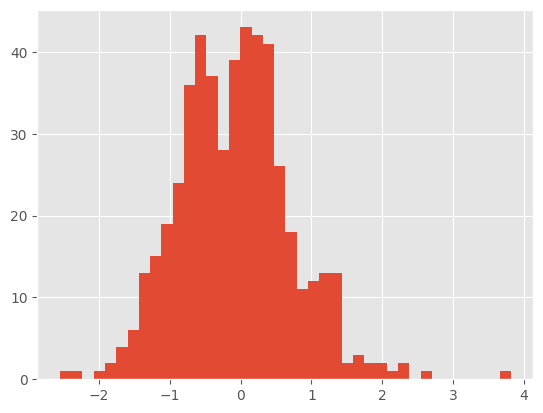

In [606]:
plt.hist(u[0], bins=40)
plt.show()

In [612]:
samples = nsde_flow.sample(10)
samples = samples[(~(np.max(samples, axis=1) > 1.5*np.max(data))) & (~(np.min(samples, axis=1) < 1.5*np.min(data)))]

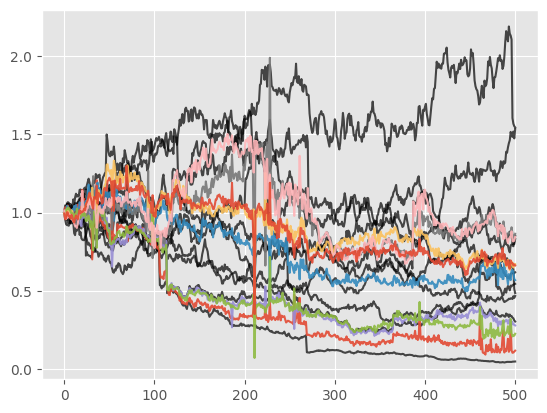

In [613]:
plt.plot(data_tensor.T, color='black', alpha=0.7, label='Real')
plt.plot(samples[:, :].T, alpha=0.9, label='Synth')

# plt.legend()
plt.show()

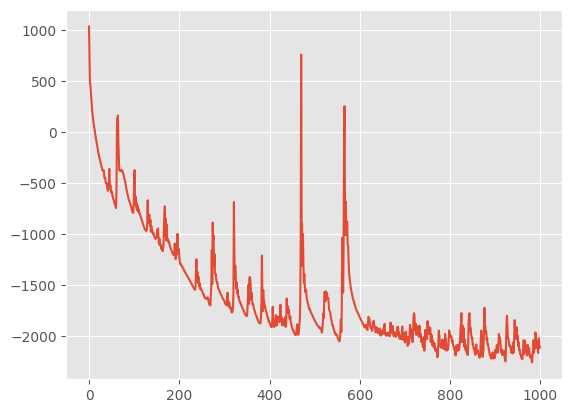

In [614]:
plt.plot(losses)
plt.show()

In [615]:
nsde_flow.xiP

Parameter containing:
tensor([0.0297], requires_grad=True)

In [378]:
u = data_tensor.T
h_dim = len(u[0])
time_steps = len(u)
dt = torch.FloatTensor([1/time_steps])

In [379]:
u[0]

tensor([-0.0718, -0.2635, -0.2614, -0.0788,  0.0909, -0.1032,  0.1792,  0.0754,
        -0.0639, -0.4522])

In [418]:
sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, 30)

tensor([[-0.0718, -0.2635, -0.2614,  ...,  0.0754, -0.0639, -0.4522],
        [-0.0722, -0.2938, -0.2676,  ...,  0.0713, -0.0643, -0.4478],
        [-0.0726, -0.3112, -0.2505,  ...,  0.0738, -0.0611, -0.4506],
        ...,
        [ 0.1988,  0.3964,  2.3812,  ..., -0.6767, -0.1604,  0.7804],
        [ 0.1985,  0.4017,  2.3676,  ..., -0.6771, -0.1606,  0.7770],
        [ 0.1979,  0.4090,  2.3813,  ..., -0.6755, -0.1612,  0.7771]],
       grad_fn=<SqueezeBackward0>)

In [516]:
class Intensity(nn.Module):
    def __init__(self) -> None:
        super(Intensity, self).__init__()
        
        self.xi = torch.nn.Parameter(torch.rand(1), requires_grad=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(1, 1)
        
    def forward(self):
        return self.relu(self.fc(self.xi))

In [517]:
xi = Intensity()
optim_xi = optim.Adam(xi.parameters(), lr=3e-4)

In [518]:
xi()

tensor([0.7785], grad_fn=<ReluBackward0>)

In [524]:
drift = Drift(h_dim)
diffusion = Diffusion(h_dim, 1)
jump = Jump(h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
scheduler_drift = optim.lr_scheduler.MultiStepLR(optim_drift, milestones=[20], gamma=0.3)
scheduler_diffusion = optim.lr_scheduler.MultiStepLR(optim_diffusion, milestones=[20], gamma=0.3)
scheduler_jump = optim.lr_scheduler.MultiStepLR(optim_jump, milestones=[20], gamma=0.3)

epochs_j = tqdm(range(40))
loss_array_j = []
mse_j = nn.MSELoss()

base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
z = u[0].view(1, -1)
xiP = 30

for _ in epochs_j:  
    # z = base_dist.rsample((10, ))
    
    # xiP = xi()
    
    x = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, xiP)
    # inv_sol = sdeint_jump_inverse(drift, diffusion, jump, dt, x.detach(), time_steps, h_dim).detach()
    sol = x
    
    loss_v = mse_j(sol, u) + torch.mean((sol[0] - u[0])**2)
    
    # for dp in drift.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in diffusion.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in jump.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_xi.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_xi.step()
    
    scheduler_drift.step()
    scheduler_diffusion.step()
    scheduler_jump.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())


Loss: 0.11530408263206482: 100%|██████████| 40/40 [04:04<00:00,  6.10s/it]


In [514]:
xi()

tensor([0.4879], grad_fn=<ReluBackward0>)

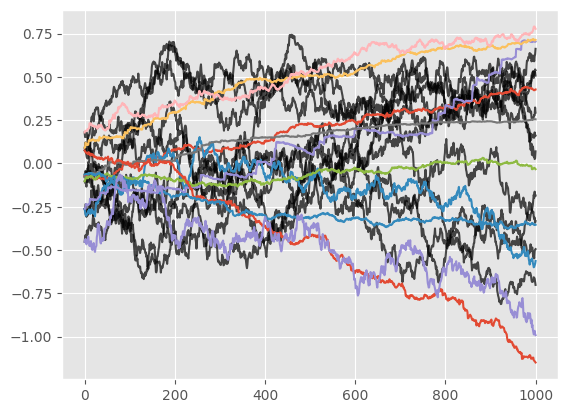

In [529]:
sol = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, 30)

plt.plot(u, alpha=0.7, color='black')
plt.plot(sol.detach().numpy())

plt.show()

In [531]:
sol.size()

torch.Size([1001, 10])

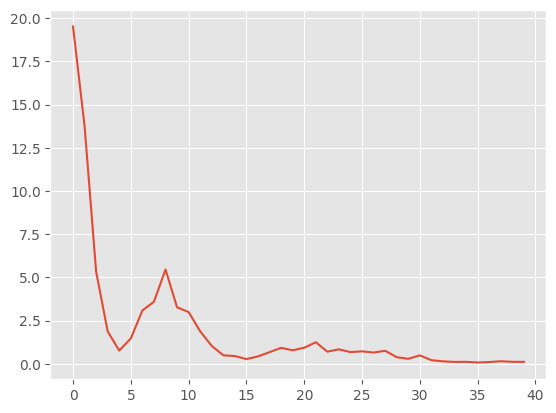

In [528]:
plt.plot(loss_array_j)
plt.show()

In [402]:
np.random.poisson(30 * dt, size=(time_steps, 1, h_dim)).sum()

282

In [403]:
time_steps*h_dim

10010

## NSDE for each record

In [66]:
u = data_tensor.T
h_dim = len(u[0])
time_steps = h_dim
dt = torch.FloatTensor([1/time_steps])

drift = Drift(1)
diffusion = Diffusion(1, 1)
jump = Jump(1)
f = Operator_F(h_dim, h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=3e-4)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4)
optim_jump = optim.Adam(jump.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)

In [67]:
# h_dim

10

In [430]:
epochs_j = tqdm(range(10))
loss_array_j = []
mse_j = nn.MSELoss()

for _ in epochs_j:  
    sol = torch.stack(sdeint_jump_1d(drift, diffusion, jump, dt, u[:, 0].view(-1, 1), time_steps)).squeeze(-1).T
    
    loss_v = mse_j(f(sol), u)

    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_f.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())

Loss: 0.1502450555562973: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


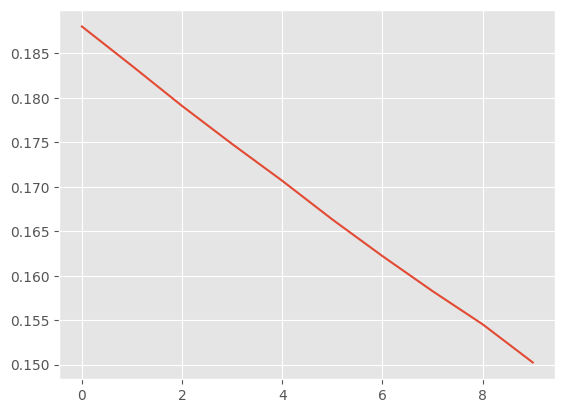

In [431]:
plt.plot(loss_array_j)
plt.show()

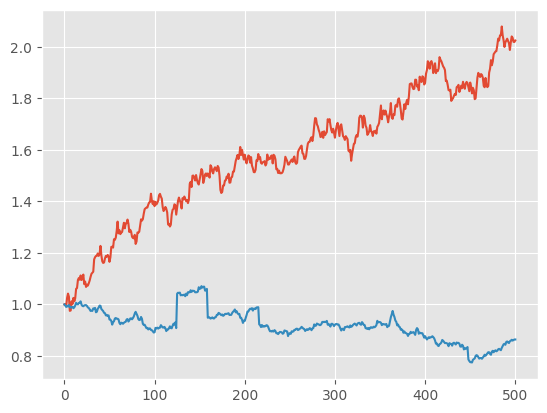

In [435]:
plt.plot(sol.detach().numpy().T)
plt.plot(u[0])
plt.show()

In [201]:
# data_tensor = data_tensor.view(1, -1)

## NSDE

In [204]:
u = data_tensor
h_dim = len(u[0])
time_steps = 50
dt = torch.FloatTensor([1/time_steps])

In [205]:
nsde = NSDE(h_dim, dt, time_steps)

nsde.fit(u, epochs=100)

Loss: 463.4156: 100%|██████████| 100/100 [00:04<00:00, 20.24it/s]


In [206]:
s_tilde = nsde.sample(10)

In [207]:
s_tilde

tensor([[0.9727, 0.9809, 0.9770,  ..., 0.9024, 0.9251, 0.9222],
        [0.9727, 0.9809, 0.9770,  ..., 0.9024, 0.9252, 0.9222],
        [0.9727, 0.9809, 0.9770,  ..., 0.9024, 0.9251, 0.9221],
        ...,
        [0.9727, 0.9809, 0.9770,  ..., 0.9024, 0.9252, 0.9222],
        [0.9727, 0.9809, 0.9770,  ..., 0.9024, 0.9252, 0.9222],
        [0.9727, 0.9809, 0.9770,  ..., 0.9023, 0.9251, 0.9221]])

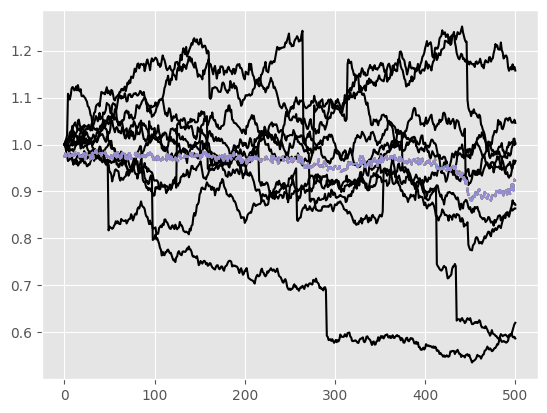

In [208]:
plt.plot(u.T, color='black')
plt.plot(s_tilde.T, '--')

plt.show()

## NSDE VAE

In [25]:
u = data_tensor
h_dim = len(u[0])
data_dim = len(data_tensor[0])
time_steps = 50
dt = torch.FloatTensor([1/time_steps])

In [23]:
set_A = torch.stack(list(map(lambda x: create_setA(x), u)))

In [24]:
set_A.size()

torch.Size([10, 501, 501])

In [38]:
h_dim_v = 1
z_dim = 30
data_dim = len(data_tensor[0])

phi = Phi(z_dim, 1, 1)
mu_v = Mu_V(1, h_dim_v, data_dim)
sigma_v = Sigma_V(1, h_dim_v, data_dim)
f = Operator_F(h_dim, h_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4)
optim_mu_v = optim.Adam(mu_v.parameters(), lr=3e-4)
optim_sigma_v = optim.Adam(sigma_v.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)


epochs_v = tqdm(range(100))
loss_array_v = []
mse_v = nn.MSELoss()

# for _ in epochs_v:  
#     u0 = phi(torch.randn(z_dim), u[0])
#     v_sol = sdeint_V(mu_v, sigma_v, dt, u0, len(u[0]), h_dim_v, set_A)
    
#     loss_v = mse_v(v_sol, u[0].view(-1, 1)) + (u0 - u[0][0])**2
    
#     optim_phi.zero_grad()
#     optim_mu_v.zero_grad()
#     optim_sigma_v.zero_grad()
    
#     loss_v.backward()
    
#     optim_phi.step()
#     optim_mu_v.step()
#     optim_sigma_v.step()
    
#     epochs_v.set_description(f'Loss: {loss_v.item()}')
#     loss_array_v.append(loss_v.item())

for _ in epochs_v:  
    v_array = torch.zeros(size=(u.size(0), h_dim, 1))

    for i in range(u.size(0)):
        u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
        v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
        v_array[i] = v_sol
        
    v_array = v_array.squeeze(2)
    
    v_array = f(v_array)
    
    
    loss_v = mse_v(v_array, u) + torch.mean((u0 - u[:, 0])**2)
    
    optim_phi.zero_grad()
    optim_mu_v.zero_grad()
    optim_sigma_v.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_phi.step()
    optim_mu_v.step()
    optim_sigma_v.step()
    optim_f.step()
    
    epochs_v.set_description(f'Loss: {loss_v.item()}')
    loss_array_v.append(loss_v.item())

Loss: 0.10696950554847717: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


In [39]:
v_array = torch.zeros(size=(u.size(0), h_dim, 1))

for i in range(u.size(0)):
    u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
    v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
    v_array[i] = v_sol
    
v_array = v_array.squeeze(2).detach().cpu().numpy()

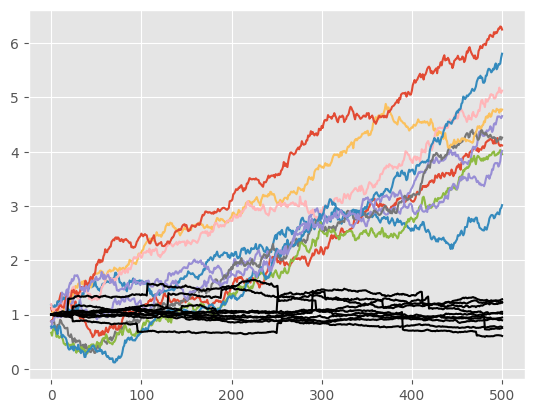

In [40]:
plt.plot(v_array.T)
plt.plot(u.T, color='black')
plt.show()

In [41]:
# plt.plot(sdeint_V(mu_v, sigma_v, dt, phi(torch.randn(z_dim), u[0]), len(u[0]), h_dim_v, set_A[0]).detach().numpy())
# plt.plot(u[0])
# plt.show()

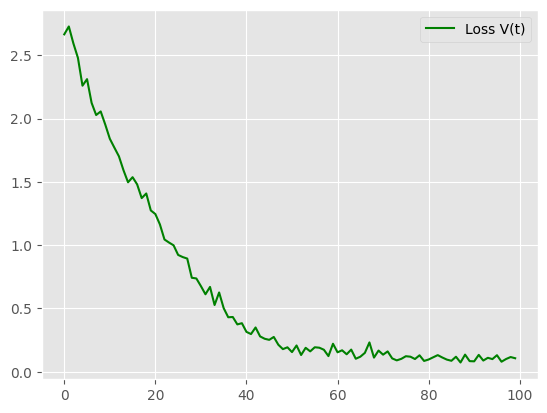

In [43]:
plt.plot(loss_array_v, label='Loss V(t)', color='green')

plt.legend()
plt.show()

In [438]:
nsde_vae = NSDE_VAE(h_dim, time_steps, dt)
# 20*2001 u.size(0) *

In [439]:
loss_array, loss_array_v, logvar_array = nsde_vae.fit(u, set_A, u[:, 0].view(-1, 1), epochs=200)

  0%|          | 0/200 [00:07<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1002 and 501x128)

In [486]:
samples = nsde_vae.sample(13, set_A, u[:, 0].view(-1, 1))[:, 0, :]

In [487]:
samples

array([[1.0004368 , 1.0071697 , 0.9829184 , ..., 0.97543925, 0.98205006,
        0.98787427],
       [1.0120256 , 1.0014377 , 1.0114166 , ..., 0.9797573 , 0.98130065,
        0.9941142 ],
       [1.0130962 , 1.0113313 , 1.0085487 , ..., 0.9832935 , 0.9928936 ,
        0.9854418 ],
       ...,
       [1.0132198 , 0.99813896, 0.9958266 , ..., 0.9828849 , 0.979342  ,
        0.98201984],
       [0.98419523, 0.98408425, 0.9972365 , ..., 0.9727942 , 0.96414983,
        0.9733106 ],
       [1.0046521 , 0.9917535 , 0.9922377 , ..., 0.9853686 , 0.96712434,
        0.97948486]], dtype=float32)

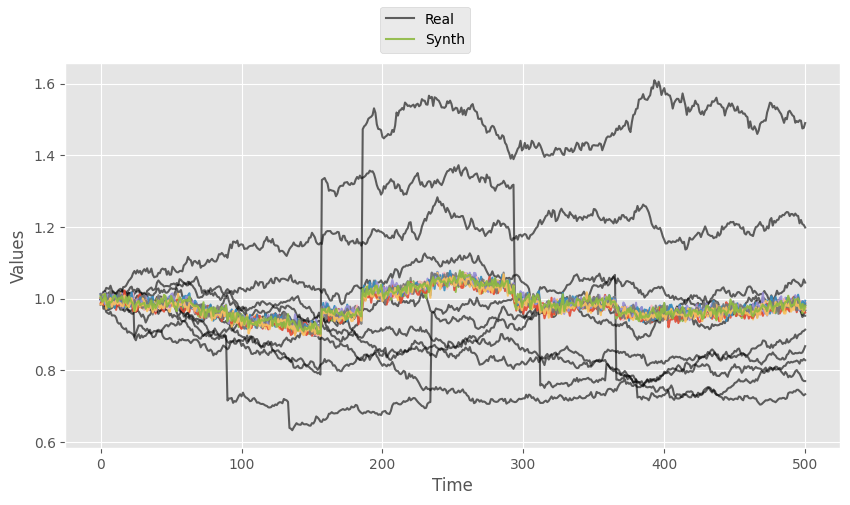

In [488]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(u.T, color='black', alpha=0.6, label='Real')
plt.plot(samples.T, alpha=0.9, label='Synth')

handles, labels = ax.get_legend_handles_labels()
fig.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')

# plt.legend()
plt.ylabel('Values')
plt.xlabel('Time')
plt.show()

In [491]:
loss_array = np.array(loss_array).T

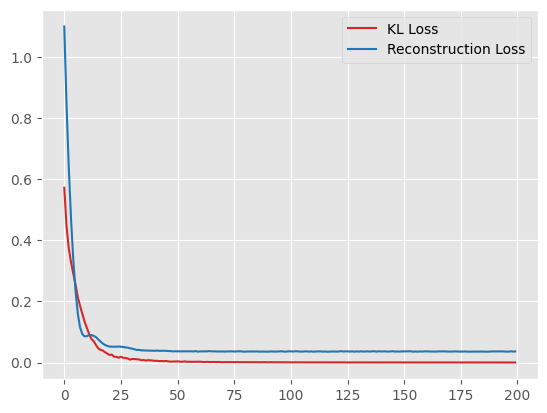

In [492]:
plt.plot(loss_array[0], color='tab:red', label='KL Loss')
plt.plot(loss_array[1], color='tab:blue', label='Reconstruction Loss')
# plt.plot(loss_array_v, color='green', label='Loss $V(t)$')

plt.legend()
plt.show()

In [493]:
logvar_array[0][-1]

tensor([[ 0.0714, -0.0736,  0.0059,  ...,  0.0683, -0.0161,  0.0662],
        [ 0.0758, -0.0810,  0.0010,  ...,  0.0798, -0.0234,  0.0662],
        [ 0.0739, -0.0829,  0.0012,  ...,  0.0827, -0.0248,  0.0654],
        ...,
        [ 0.0681, -0.0833,  0.0015,  ...,  0.0884, -0.0286,  0.0633],
        [ 0.0682, -0.0827,  0.0023,  ...,  0.0877, -0.0285,  0.0630],
        [ 0.0677, -0.0831,  0.0001,  ...,  0.0909, -0.0298,  0.0624]],
       grad_fn=<AddmmBackward0>)

In [494]:
logvar_array[1][-1]

tensor([[ 0.0476, -0.0492, -0.0003,  ...,  0.0400, -0.0058,  0.0670],
        [ 0.0493, -0.0469, -0.0078,  ...,  0.0359, -0.0092,  0.0673],
        [ 0.0505, -0.0457, -0.0094,  ...,  0.0348, -0.0115,  0.0671],
        ...,
        [ 0.0513, -0.0432, -0.0132,  ...,  0.0347, -0.0152,  0.0675],
        [ 0.0514, -0.0434, -0.0123,  ...,  0.0345, -0.0151,  0.0676],
        [ 0.0512, -0.0424, -0.0149,  ...,  0.0347, -0.0160,  0.0666]],
       grad_fn=<AddmmBackward0>)

In [465]:
np.mean(list(map(lambda x,y: wasserstein_distance(x, y), samples, u)))

0.17737538582153978

In [173]:
class NSDEFunction(nn.Module):
    def __init__(self, hidden, in_size, out_size):

        super(NSDEFunction, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        

        self.sig_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        self.mu_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)

    def forward(self, x):
        sig = self.sig_net(x)
        z = x * torch.exp(sig) + self.mu_net(x)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob

    def inverse(self, z):
        sig_in = self.sig_net(z)
        x = (z - self.mu_net(z)) * torch.exp(-sig_in)

        return x

In [77]:
z_dim = 15
h_dim = 1
data_dim = 1
dt = torch.FloatTensor([1/len(data_tensor)])

phi = Phi(z_dim + len(data_tensor), h_dim, data_dim + 10)
drift = Drift(h_dim)
diffusion = Diffusion(h_dim)
jump = Jump(h_dim)
f = Operator_F(h_dim, data_dim)
g = Operator_G(h_dim, data_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_drift = optim.Adam(drift.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_jump = optim.Adam(jump.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_f = optim.Adam(f.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)
optim_g = optim.Adam(g.parameters(), lr=3e-4, betas=(0.9, 0.999), amsgrad=True)

In [121]:
def sdeint_inverse(drift, diffusion, jump, dt, x, n, h_dim):
    solutions = torch.zeros(n, h_dim)
    
    if h_dim != 1:
        
        for j in range(1):
            solution = []
            solution.append(x0)
            t = torch.FloatTensor([0])
            # xiP = 10
            # poisson_distr = np.random.poisson(xiP * dt, n + 1)
            # zJ = np.random.normal(muj, sigmaj, n + 1)
        
            for i in range(n - 1):
                x_next = solution[i] + drift(t, solution[i].view(1, -1)) * dt +\
                    diffusion(t, solution[i].view(1, -1)) * torch.sqrt(dt) * torch.FloatTensor(np.random.normal(0, 1, size=(1, h_dim)))
                    # jump(t, solution[i].view(1, -1)) * poisson_distr[i]
                    
                t = t + dt
                    
                solution.append(x_next)
                
            solution = torch.stack(solution, 1).squeeze()
            
            solutions = solutions + solution
            
        return torch.div(solutions, 1)
    
    else:
        for j in range(1):
            # solution = []
            # solution.append(x[-1])
            solution = torch.zeros(n)
            solution[-1] = x[-1]
            
            t = torch.FloatTensor([1])
        
            for i in range(n-1, 0, -1):
                # x_next = solution[i] + drift(t, solution[i]) * dt +\
                #     diffusion(t, solution[i]) * torch.sqrt(dt) * torch.FloatTensor([np.random.normal(0, 1)])
                # print(t, solution[i].unsqueeze(0))
                x_prev = solution[i] - drift(t, solution[i].view(-1, 1)) * dt - diffusion(t, solution[i].view(-1, 1)) * torch.sqrt(dt) * torch.FloatTensor([np.random.normal(0, 1)])
                    
                t = t - dt
                    
                solution[i-1] = x_prev
            # solution = torch.stack(solution, 1).squeeze()
            # solution = solution.view(-1, 1)
            
            # solutions = solutions + solution
            
        return solution[0].view(-1,1)

In [122]:
sdeint_inverse(drift, diffusion, jump, dt, torch.FloatTensor(x_array.T[0]), n, h_dim)

tensor([[1.3264]], grad_fn=<ViewBackward0>)

In [110]:
class NSDEFunction(nn.Module):
    def __init__(self, hidden, in_size, out_size):

        super(NSDEFunction, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        

        self.sig_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        self.mu_net = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        
        self.phi_mu = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        
        self.phi_sig = nn.Sequential(
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )

        base_mu, base_cov = torch.zeros(out_size), torch.eye(out_size)
        self.base_dist = MultivariateNormal(base_mu, base_cov)
        
    

    def forward(self, x):
        noise = torch.mean(torch.FloatTensor(dclProcess(10, z_dim)), dim=0)
        dt = torch.FloatTensor([1/len(x)])
        char_x0 = x.unsqueeze(0)
 
        x0 = torch.cat([noise, char_x0], dim=1)
        xi0 = x0 * torch.exp(self.phi_sig(x0)) + self.phi_mu(x0)
        
        xi = sdeint(drift, diffusion, jump, dt, xi0, len(data_tensor), h_dim)
        x = xi.view(-1).unsqueeze(0)
    
        sig = self.sig_net(x)
        z = x * torch.exp(sig) + self.mu_net(x)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)

        return z, log_pz, log_jacob

    def inverse(self, z):
        x = (z - self.mu_net(z)) * torch.exp(-self.sig_net(z))
        
        dt = torch.FloatTensor([1/len(z)])
        xi0 = sdeint_inverse(drift, diffusion, jump, dt, x, len(data_tensor), h_dim)
        
        x0 = (xi0 - self.phi_mu(xi0)) * torch.exp(-self.phi_sig(xi0))
        out = x0[z_dim:]

        return out

In [190]:
class NSDEFlow(nn.Module):
    def __init__(self, hidden, n_flows, in_size, out_size):
        super(NSDEFlow, self).__init__()
        
        self.in_size = in_size
        self.out_size = out_size

        self.bijections = nn.ModuleList(
            [NSDEFunction(hidden, self.in_size, self.out_size) for _ in range(n_flows)]
        )

    def forward(self, x):
        log_jacobs = []

        for bijection in self.bijections:

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs)

    def inverse(self, z):

        for bijection in reversed(self.bijections):

            z = bijection.inverse(z)

        return z.detach().numpy()
    
    def fit(self, X, epochs=200, learning_rate=3e-4):
        
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

        losses = []
        
        epochs = tqdm(range(epochs))

        for _ in epochs:
            z, log_pz, log_jacob = self.forward(X)
            loss = (-log_pz - log_jacob).mean()

            losses.append(loss.detach().numpy())

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')

        return losses
    
    def sample(self, n_samples):
        mu, cov = torch.zeros(self.out_size), torch.eye(self.out_size)
        p_Z = MultivariateNormal(mu, cov)
        z = p_Z.rsample(sample_shape=(n_samples,))

        X_sample = self.inverse(z)

        return X_sample

In [191]:
nsde_flow = NSDEFlow(100, 15, len(data), len(data))

In [192]:
losses = nsde_flow.fit(data_tensor.view(1, -1), epochs=500)

Loss: -11565.1562: 100%|██████████| 500/500 [00:40<00:00, 12.32it/s]


In [193]:
synth_data = nsde_flow.sample(1)

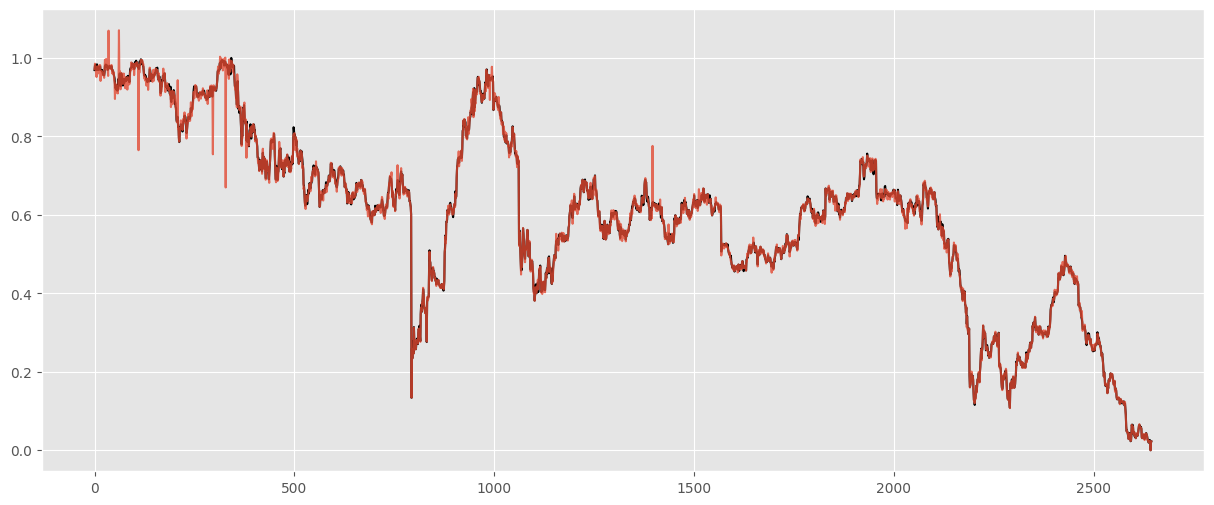

In [195]:
plt.subplots(figsize=(15, 6), dpi=100)

plt.plot(data, color='black')
plt.plot(synth_data[0], alpha=0.8)

plt.show()